In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
from qiskit_rigetti import RigettiQCSBackend, RigettiQCSJob, RigettiQCSProvider
from qiskit_rigetti import QuilCircuit

In [2]:
import pickle
with open("readout_error_aspen-11_0to7.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
data.keys()

dict_keys(['result', 'meas_fitter', 'cal_matrix', 'time'])

In [4]:
from qiskit.result import Result
import pickle
def separate_results(one_job_results):
    return [Result(backend_name=one_job_results.backend_name,
                   backend_version=one_job_results.backend_version,
                   qobj_id=one_job_results.qobj_id,
                   job_id=one_job_results.job_id,
                   success=True,
                   results=[results]) for results in one_job_results.results]

def merge_results(results_list):
    results = []
    for res in results_list:
        results += res.results
    return Result(backend_name=results_list[0].backend_name,
                  backend_version=results_list[0].backend_version,
                  qobj_id=results_list[0].qobj_id,
                  job_id=results_list[0].job_id,
                  success=True,
                  results=results)

In [5]:
results = separate_results(data["result"])

In [6]:
tensored_results = [results[0], results[-1]]

In [7]:
tensored_result = merge_results(tensored_results)

In [8]:
from qiskit.ignis.mitigation import TensoredMeasFitter, CompleteMeasFitter, complete_meas_cal

In [9]:
num_qubits = 8
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr)
len(meas_calibs)

256

In [10]:
cmf = CompleteMeasFitter(data["result"], state_labels)

In [11]:
cmf.cal_matrix

array([[0.55285645, 0.06384277, 0.03637695, ..., 0.        , 0.        ,
        0.        ],
       [0.01062012, 0.49731445, 0.00097656, ..., 0.        , 0.        ,
        0.        ],
       [0.03393555, 0.00280762, 0.56237793, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.48522949, 0.00061035,
        0.03686523],
       [0.        , 0.        , 0.        , ..., 0.00402832, 0.53210449,
        0.05236816],
       [0.        , 0.        , 0.        , ..., 0.04736328, 0.01049805,
        0.50598145]])

In [12]:
tmf = TensoredMeasFitter(tensored_result, mit_pattern=[[i] for i in range(8)])

In [13]:
tmf.cal_matrices

[array([[0.98364258, 0.10070801],
        [0.01635742, 0.89929199]]),
 array([[0.94384766, 0.07263184],
        [0.05615234, 0.92736816]]),
 array([[0.94445801, 0.12524414],
        [0.05554199, 0.87475586]]),
 array([[0.81604004, 0.13793945],
        [0.18395996, 0.86206055]]),
 array([[0.93054199, 0.09289551],
        [0.06945801, 0.90710449]]),
 array([[0.90795898, 0.0390625 ],
        [0.09204102, 0.9609375 ]]),
 array([[0.98486328, 0.05224609],
        [0.01513672, 0.94775391]]),
 array([[0.9329834 , 0.03234863],
        [0.0670166 , 0.96765137]])]

In [14]:
import matplotlib.pyplot as plt
import numpy as np

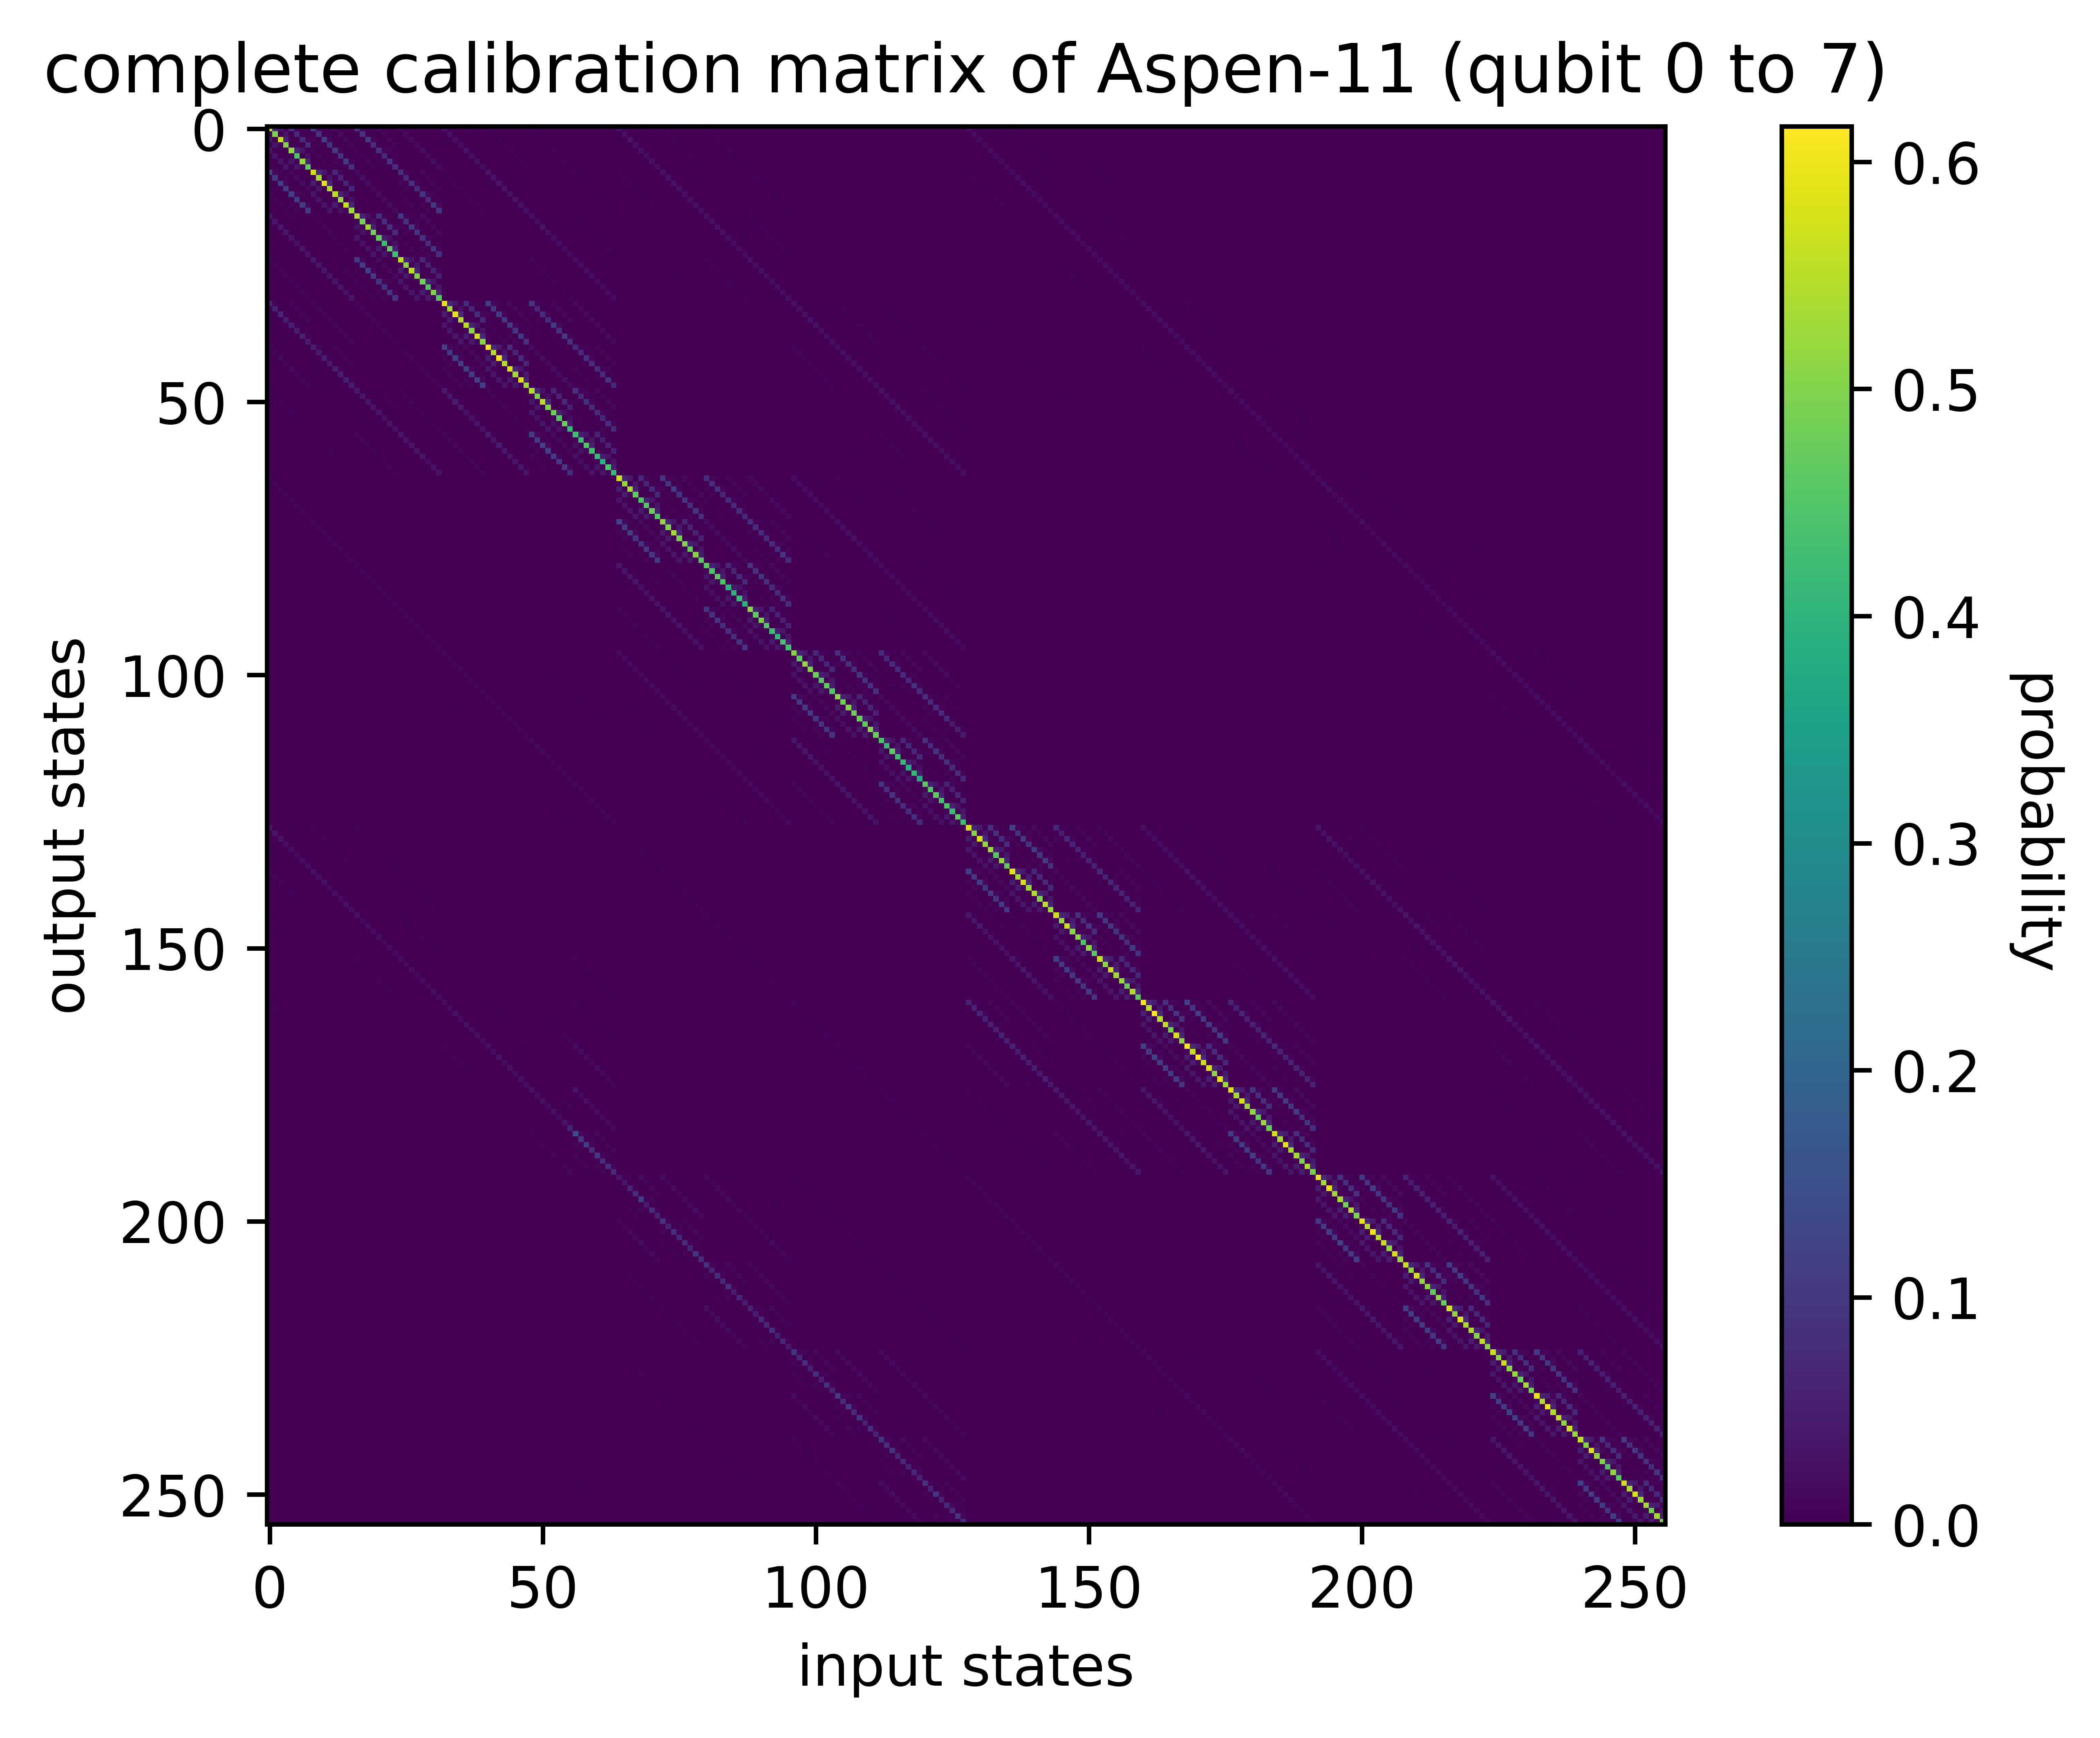

In [15]:
fig, ax = plt.subplots(dpi = 1000)
im = ax.imshow(cmf.cal_matrix)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("probability", rotation=-90, va="bottom")
fig.tight_layout()
plt.xlabel("input states")
plt.ylabel("output states")
plt.title("complete calibration matrix of Aspen-11 (qubit 0 to 7)")
plt.show()

In [16]:
tensored_cal_matrix = 1.
for mat in tmf.cal_matrices:
    tensored_cal_matrix = np.kron(tensored_cal_matrix, mat)
tensored_cal_matrix.shape

(256, 256)

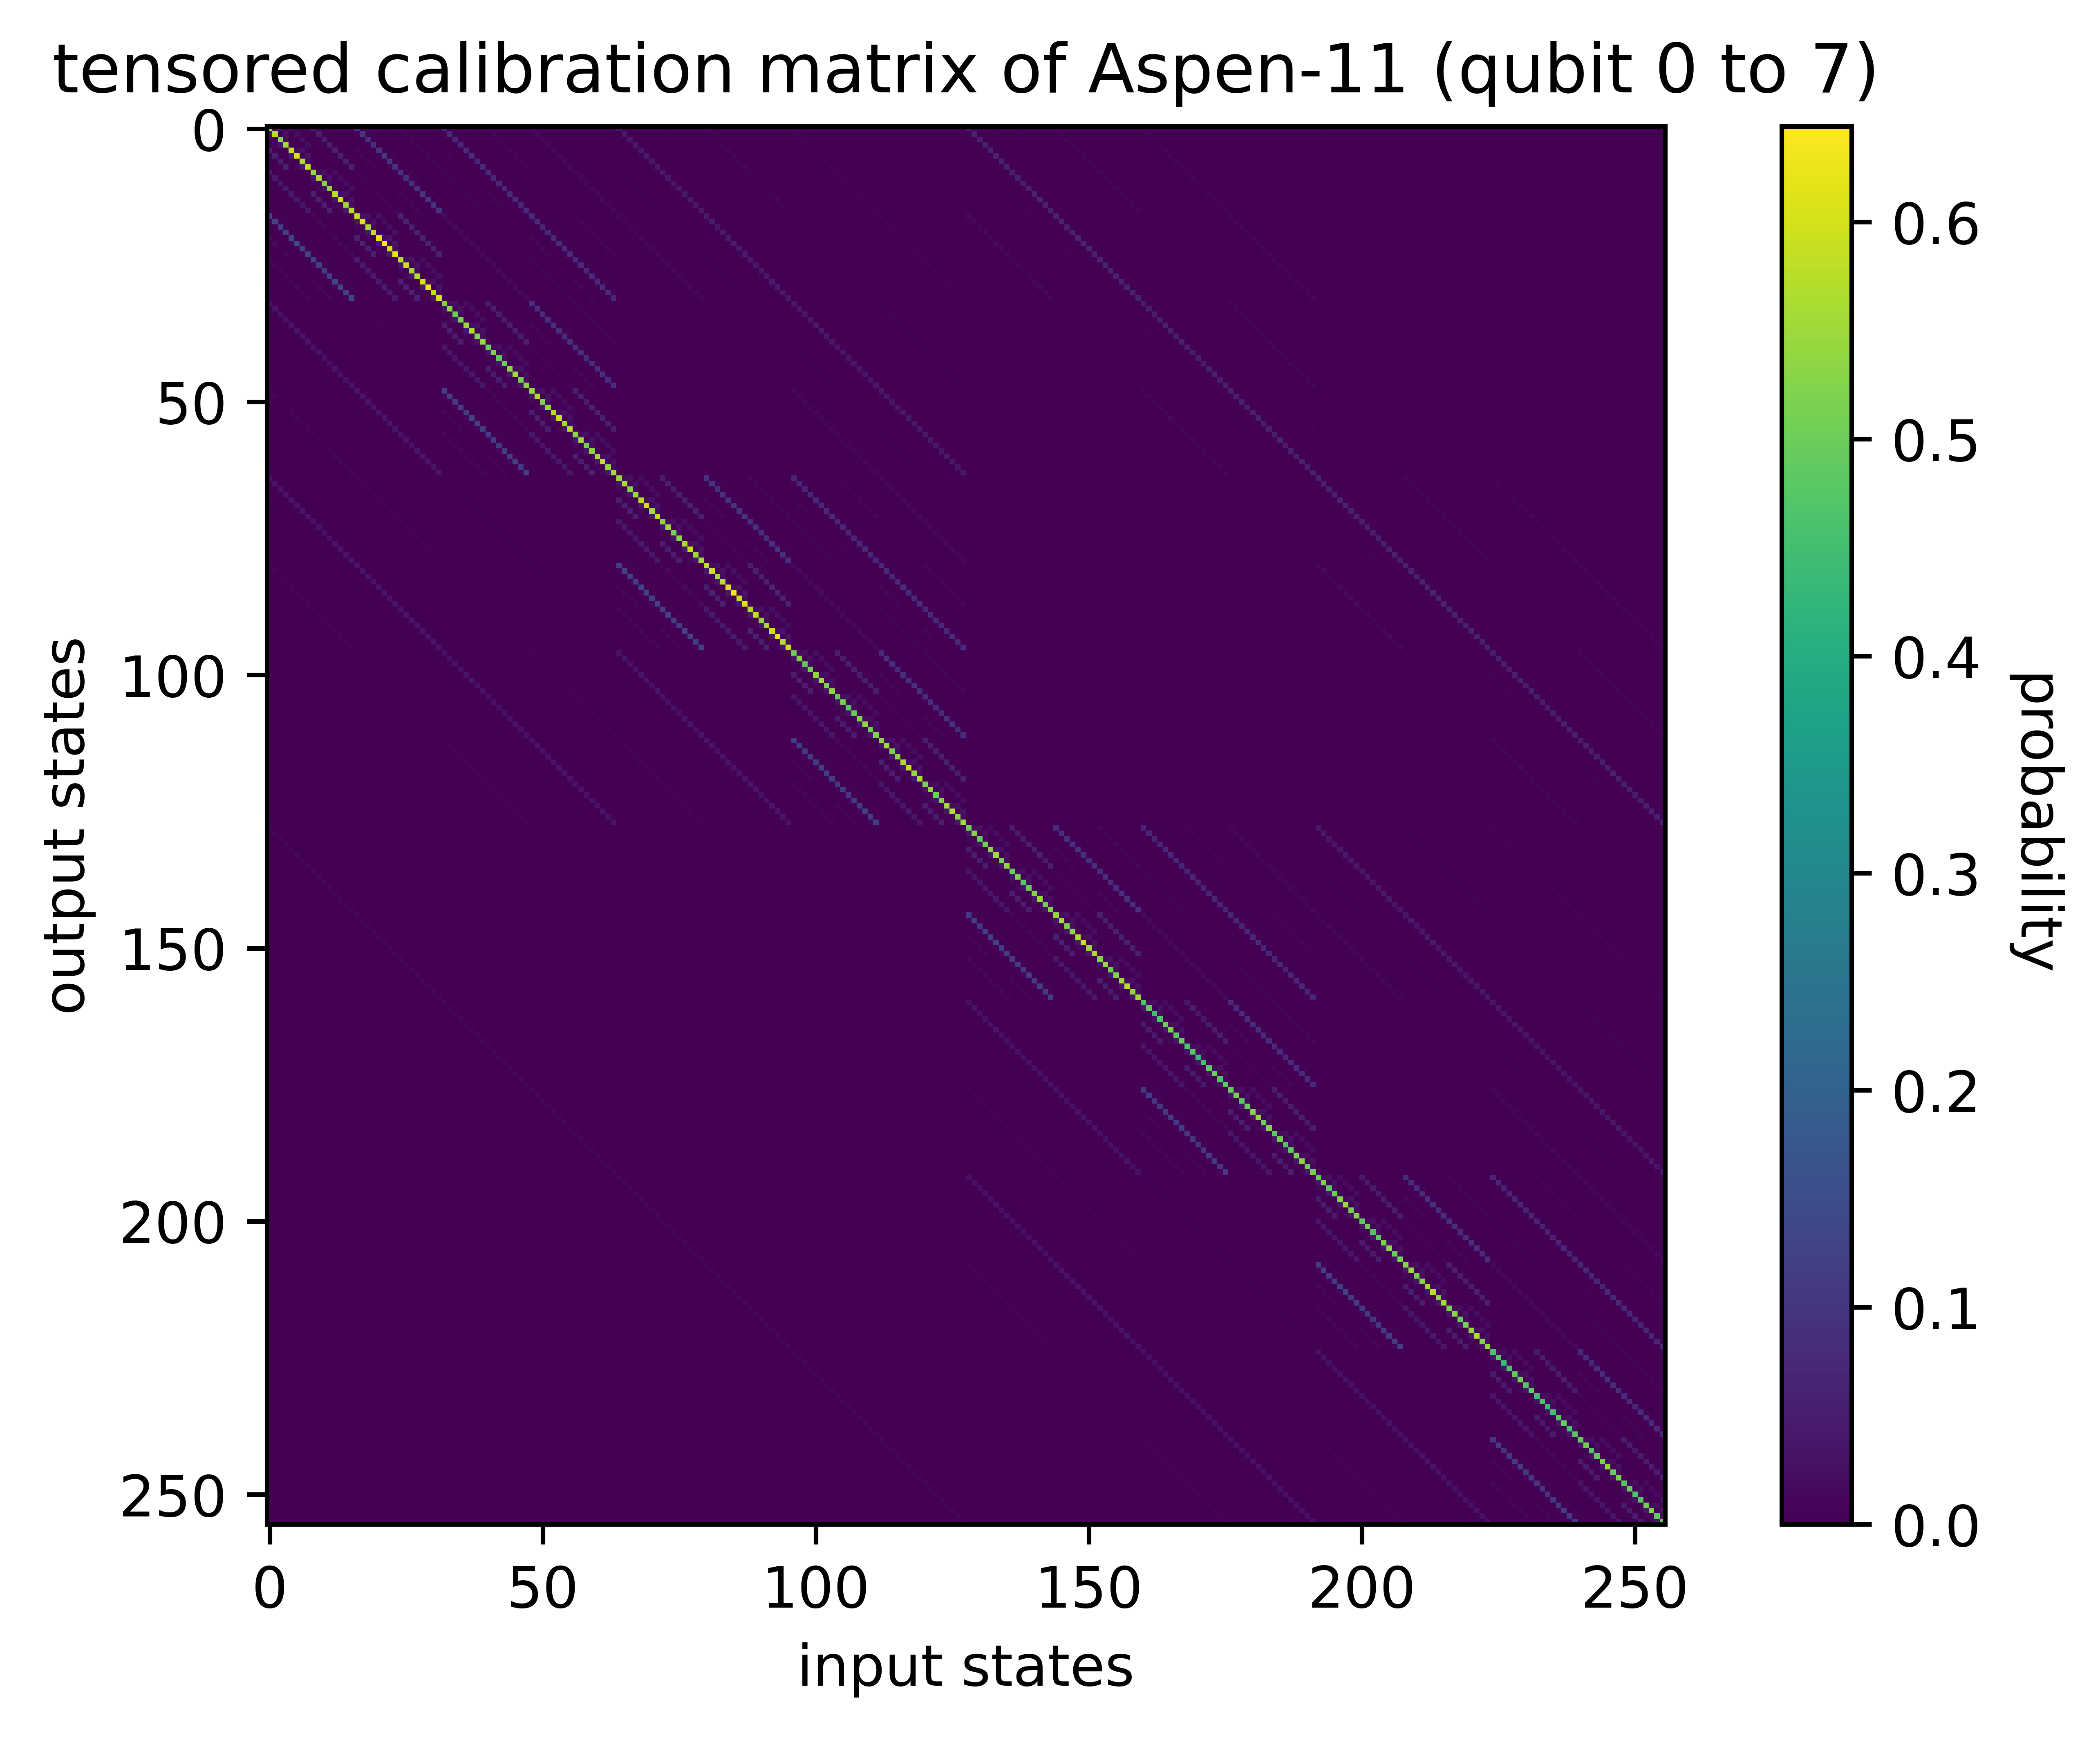

In [17]:
fig, ax = plt.subplots(dpi = 1000)
im = ax.imshow(tensored_cal_matrix)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("probability", rotation=-90, va="bottom")
fig.tight_layout()
plt.xlabel("input states")
plt.ylabel("output states")
plt.title("tensored calibration matrix of Aspen-11 (qubit 0 to 7)")
plt.show()

In [19]:
import pickle
with open("cmf_tmf.pkl", "wb") as f:
    pickle.dump({"cmf": cmf, "tmf": tmf}, f)

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table